In [1]:
import sys
sys.path.append("/b2p")

In [2]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import os
from glob import glob 
import rasterio
from rasterio import features
from rasterio.windows import Window
import geopandas as gpd
import numpy as np
import copy
from tqdm.notebook import tqdm 
import warnings
# filter out RuntimeWarnings, due to geopandas/fiona read file spam
# https://stackoverflow.com/questions/64995369/geopandas-warning-on-read-file
warnings.filterwarnings("ignore",category=RuntimeWarning)

<IPython.core.display.Javascript object>


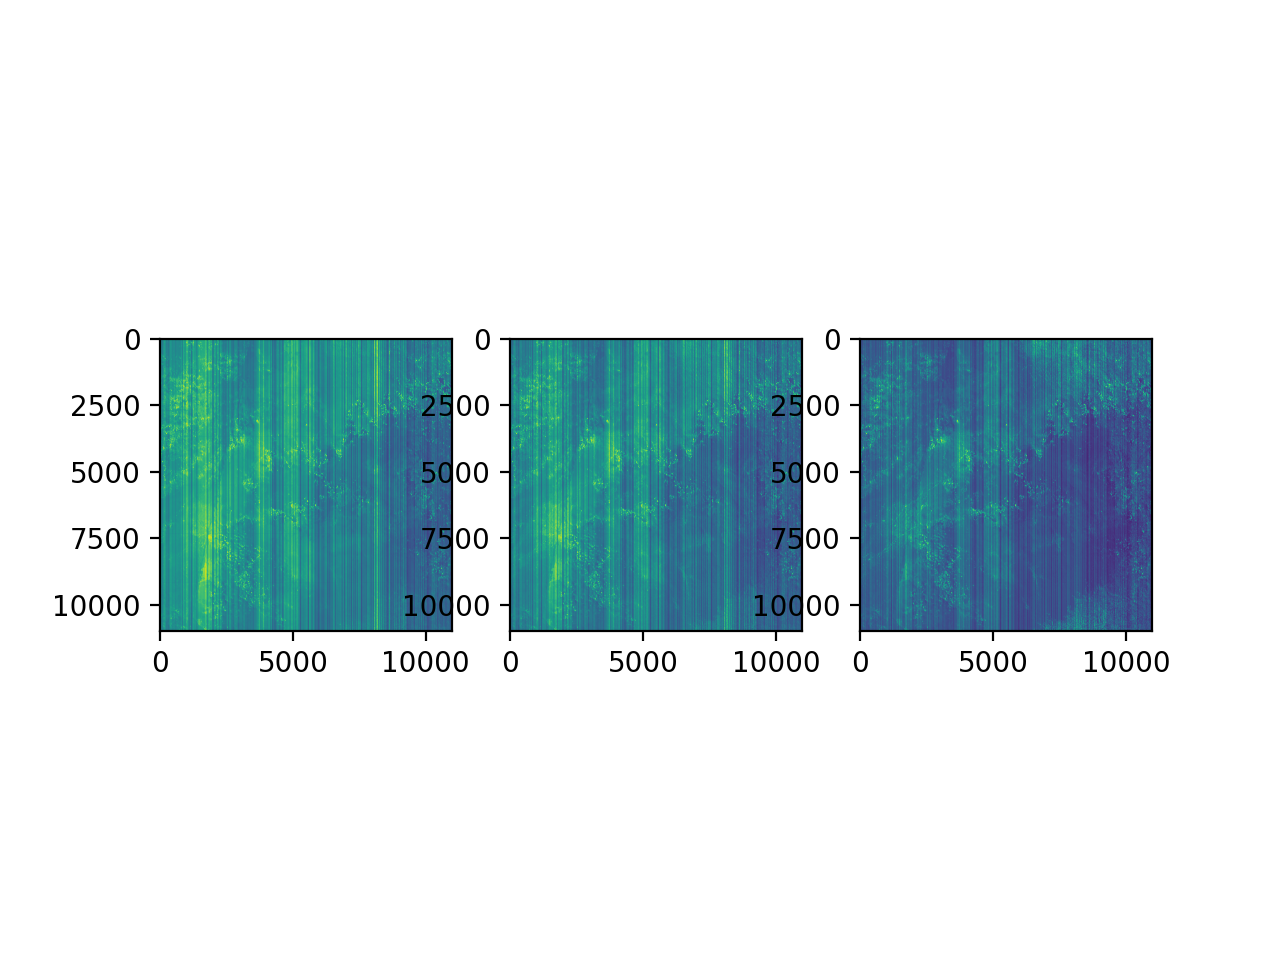

False
False
False


In [18]:
from sklearn import preprocessing as p
def plotNormalizedImg(data, ax):
    min_max_scaler = p.MinMaxScaler()
    normalizedData = min_max_scaler.fit_transform(data.astype(np.float64))*255

    normalizedData = np.round(normalizedData).astype(np.uint8)
    
    ax.imshow(normalizedData)
    plt.show()
with rasterio.open('./data/test_composite/Rwanda/all/35MPS_multiband.tiff') as rf:
    fig, axs = plt.subplots(1,3)
    b2 = rf.read(1)
    b3 = rf.read(2)
    b4 = rf.read(3)
    plotNormalizedImg(b2, axs[0])
    print(np.isnan(b2).any())
    print(np.isnan(b3).any())
    print(np.isnan(b4).any())
    plotNormalizedImg(b3, axs[1])
    plotNormalizedImg(b4, axs[2])
    plt.show()

In [ ]:
# set inputs
s2_dir = '/b2p/data/tmp_s2/Rwanda/all'
bands = ['B02', 'B03','B04']
composite_dir = './data/test_composite'
dtype = np.float32
num_slices = 6

In [ ]:
with rasterio.open(outpath, 'w', driver='Gtiff', width=g_ncols, height=g_nrows, count=1, crs=crs,
                                   transform=transform, dtype=dtype) as wf:
        wf.write(median_corrected.astype(dtype), 1)

In [ ]:
from scipy.stats import norm
dif = np.diff(median_corrected, axis=1) # right col minus left
data = dif.mean(axis=0)
mu, std = norm.fit(data)
plt.subplots()
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [ ]:
from src.api.sentinel2 import SinergiseSentinelAPI

# Download New Data

In [24]:
from src.api.sentinel2 import SinergiseSentinelAPI
buffer = 100
api = SinergiseSentinelAPI()

In [27]:
# Rwanda (first month of dry szn)
bbox = [28.7869, -3.6889, 30.9732, -0.1978]
outdir = './data/tmp_s2/Rwanda/all'
start_date = '2018-06-01'
end_date = '2018-07-31'

In [28]:
os.makedirs(outdir, exist_ok=True)
api.download(bbox, buffer, outdir, start_date, end_date)

Finding overlapping tiles... 
Found 1632 files for download. Total size of files is 86.16GB and estimated cost will be $7.75


100%|██████████| 1632/1632 [00:40<00:00, 40.01it/s] 


In [ ]:
# Uganda
d_to_bbox = { Kabarole: [30.0675, 0.1847, 30.6141, 1.0581],
    Kasese: [29.4585, -0.7429, 30.5516, 1.0038],
    Ibanda: [30.1691, -0.4964, 30.7157, 0.3770]
}
for district, bbox in d_to_bbox.items():
    outdir = os.path.join('./data/tmp_s2/Rwanda', district)
    # get first dry szn
    start_date = '2019-06-15'
    end_date = '2019-08-15'
    os.makedirs(outdir, exist_ok=True)
    api.download(bbox, buffer, outdir, start_date, end_date)
    start_date = '2019-01-01'
    end_date = '2019-02-28'